In [1]:
from scipy.io import loadmat
import scipy.io
import scipy.signal
# Of course we also need signal from Scipy too
from scipy import signal
# Importing numpy to make it possible to perform vector operations
import numpy as np
# These two libraries are for visualization
import matplotlib.pyplot as plt
from pandas import Series


def BandPassECG(Path,Fs):
    '''
    This function takes in a "path" and imports the ECG signal in .mat format
    '''
    # Import the signal
    data = scipy.io.loadmat(Path)
    data_val = data['ECGdata']
    data_val = data_val[0]
    ECG = data_val
    # Implementing the Butterworth BP filter
    W1     = 5*2/Fs                                    # --> 5 Hz cutt-off (high-pass) and Normalize by Sample Rate
    W2     = 15*2/Fs                                   # --> 15 Hz cutt-off (low-pass) and Normalize by Sample Rate
    b, a   = signal.butter(4, [W1,W2], 'bandpass')     # --> create b,a coefficients , since this is IIR we need both b and a coefficients
    ECG    = np.asarray(ECG)                           # --> let's convert the ECG to a numpy array, this makes it possible to perform vector operations 
    ECG    = np.squeeze(ECG)                           # --> squeeze
    ECG_BP = signal.filtfilt(b,a,ECG)    # --> filtering: note we use a filtfilt that compensates for the delay
    return ECG_BP,ECG

def Differentiate(ECG):
    '''
    Compute single difference of the signal ECG
    '''
    ECG_df  = np.diff(ECG)
    ECG_sq  = np.power(ECG_df,2)
    return np.insert(ECG_sq,0, ECG_sq[0])

def MovingAverage(ECG,N=30):
    '''
    Compute moving average of signal ECG with a rectangular window of N
    '''
    window  = np.ones((1,N))/N
    ECG_ma  = np.convolve(np.squeeze(ECG),np.squeeze(window))
    return ECG_ma

def QRSpeaks(ECG,Fs):
    '''
    Finds peaks in a smoothed signal ECG and sampling freq Fs.
    '''
    peaks, _  = signal.find_peaks(ECG, height=np.mean(ECG), distance=round(Fs*0.200))
    return peaks


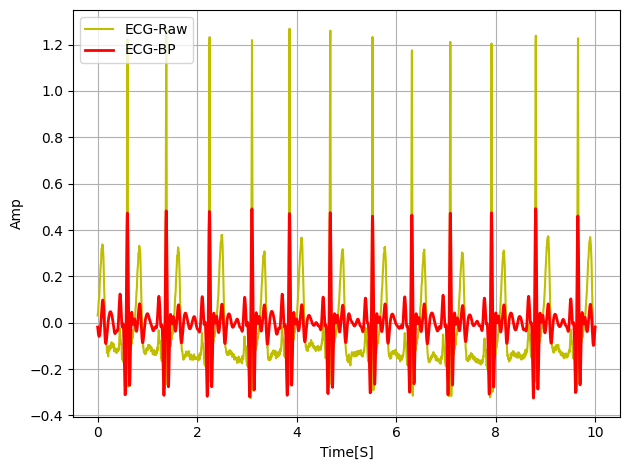

In [2]:
# Load and BP the Signal
Fs =256
Path ="/Users/nivinattudurai/Downloads/YAAD 1/ECG_GSR_Emotions/Raw Data/Multimodal/ECG/ECGdata_s1p1v1.mat"
ECG_BP,ECG_raw = BandPassECG(Path,Fs)
# Create Series and plot the first 10 seconds
ts_raw = Series(np.squeeze(ECG_raw[:10*Fs] - np.mean(ECG_raw)), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
ts_BP = Series(np.squeeze(ECG_BP[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)

# Styling the figures and colorcoding
fig = plt.figure(frameon="False"); ts_raw.plot(style='y',label='ECG-Raw') 
ts_BP.plot(style='r', label='ECG-BP',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.grid(True,'both'); plt.tight_layout(); plt.show()

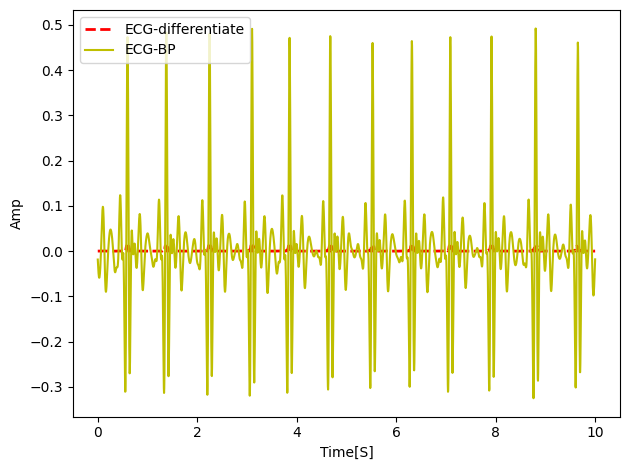

In [3]:
ECG_df = Differentiate(ECG_BP)
ts_df = Series(np.squeeze(ECG_df[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
fig = plt.figure(frameon="False"); ts_df.plot(style='r--', label='ECG-differentiate',linewidth=2.0); 
ts_BP.plot(style='y',label='ECG-BP')
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('ECG_df.png', transparent=True)

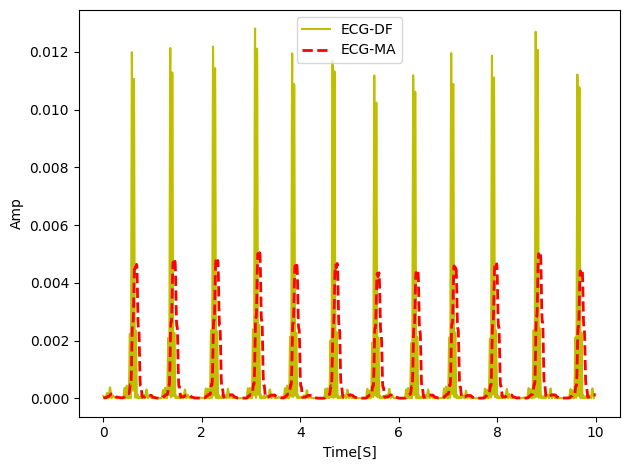

In [4]:
ECG_ma = MovingAverage(ECG_df)
ts_ma = Series(np.squeeze(ECG_ma[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
fig = plt.figure(frameon="False"); ts_df.plot(style='y',label='ECG-DF') 
ts_ma.plot(style='r--', label='ECG-MA',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('ECG_ma.png', transparent=True)

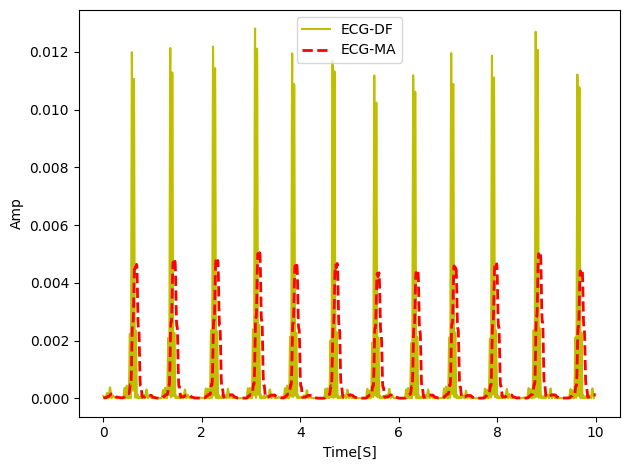

In [5]:
ECG_ma = MovingAverage(ECG_df)
ts_ma = Series(np.squeeze(ECG_ma[:10*Fs]), index=np.arange(ECG_raw[:10*Fs].shape[0])/Fs)
fig = plt.figure(frameon="False"); ts_df.plot(style='y',label='ECG-DF') 
ts_ma.plot(style='r--', label='ECG-MA',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]',); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('ECG_ma.png', transparent=True)

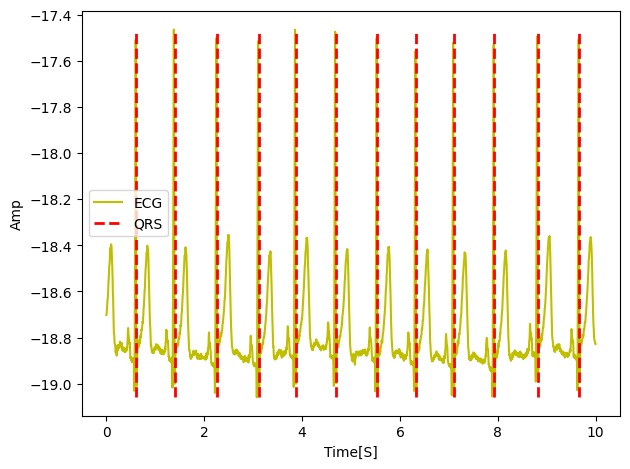

In [6]:
QRS = QRSpeaks(ECG_ma,Fs)
QRS = QRS[QRS<=10*Fs]
fig = plt.figure(frameon="False") 
plt.plot(np.arange(ECG_raw[:10*Fs].shape[0])/Fs,ECG_raw[:10*Fs],color='y',label='ECG')
plt.vlines(x=(QRS-15)/Fs,ymin=np.min(ECG_raw[:10*Fs]),ymax=np.max(ECG_raw[:10*Fs]),linestyles='dashed',color='r', label='QRS',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]'); plt.legend()
plt.tight_layout(); plt.show()
fig.savefig('QRS_pks.png', transparent=True)

In [7]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import hurst
from hurst import compute_Hc


def hurst_4(ts):
    #ts = ts if not isinstance(ts, pd.Series) else ts.to_list()
    lags = range(2, 100)
    #tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    tau = [sqrt((ts - ts.shift(-lag)).std()) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

In [9]:
#hurst_4(ts_ma)
H, c, data = hurst.compute_Hc(ECG_ma)
print(H)
#print(hurst_2(ts_ma))

0.22256042310062377
